In [ ]:
!wget https://www.dropbox.com/s/22q2dkgjqrsftjc/BARTNER-main.zip?dl=0
!unzip BARTNER-main.zip?dl=0

In [ ]:
# !pip install pytorch==1.7.0 torchvision==0.8.0 torchaudio==0.7.0 cudatoolkit=11.0 -c pytorch


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


# 本笔记本是《A Unified Generative Framework for Various NER Subtasks》论文，在CONLL03数据集上做的性能测试。


In [ ]:
!wget https://www.dropbox.com/s/lrgy5vzyy1lf6vb/conll2003.zip?dl=0 
!unzip conll2003.zip?dl=0

--2022-08-16 03:22:58--  https://www.dropbox.com/s/lrgy5vzyy1lf6vb/conll2003.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lrgy5vzyy1lf6vb/conll2003.zip [following]
--2022-08-16 03:22:59--  https://www.dropbox.com/s/raw/lrgy5vzyy1lf6vb/conll2003.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff12d94b586aa773c22beebb89.dl.dropboxusercontent.com/cd/0/inline/BrH65lpu_uO3fitj3i8mnXDJzq4qG7YKSFuMvfVskCC06g5cesQDVI_7Bsaz9-Zpce8nzhWjUJcyTiNc0FFVCUL-QiK3xdDKsgfGLt2K_w9S5-Y_93xAEO221kBmgercdOWTH0neHHgsdopNXK5PIiOsTDEh4RSYsVS8j3qDh0QnEA/file# [following]
--2022-08-16 03:22:59--  https://ucff12d94b586aa773c22beebb89.dl.dropboxusercontent.com/cd/0/inline/BrH65lpu_uO3fitj3i8mnXDJzq4qG7YKSFuMvfVskCC06g5cesQDVI_7Bsaz

In [ ]:
!pip install transformers==3.4.0

In [ ]:
# !pip install pytorch==1.7.0 torchvision==0.8.0 torchaudio==0.7.0 cudatoolkit=11.0 -c pytorch


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


In [ ]:
# !wget https://mirrors.tuna.tsinghua.edu.cn/anaconda/cloud/pytorch/win-64/pytorch-1.7.1-py3.7_cuda110_cudnn8_0.tar.bz2

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html -i https://pypi.douban.com/simple


In [ ]:
!pip install git+https://github.com/fastnlp/fastNLP@dev
!pip install git+https://github.com/fastnlp/fitlog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fastnlp/fastNLP (to revision dev) to /tmp/pip-req-build-zb_dg_1m
  Running command git clone -q https://github.com/fastnlp/fastNLP /tmp/pip-req-build-zb_dg_1m
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fastnlp/fitlog to /tmp/pip-req-build-y78pvhot
  Running command git clone -q https://github.com/fastnlp/fitlog /tmp/pip-req-build-y78pvhot


# Train部分

In [ ]:
import sys
sys.path.append('../')
import os
if 'p' in os.environ:
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['p']
    # os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import warnings
warnings.filterwarnings('ignore')
from data.pipe import BartNERPipe
from model.bart import BartSeq2SeqModel
import fitlog

from fastNLP import Trainer
from model.metrics import Seq2SeqSpanMetric
from model.losses import Seq2SeqLoss
from torch import optim
from fastNLP import BucketSampler, GradientClipCallback, cache_results

from model.callbacks import WarmupCallback
from fastNLP.core.sampler import SortedSampler
from model.generater import SequenceGeneratorModel
from fastNLP.core.sampler import  ConstTokenNumSampler
from model.callbacks import FitlogCallback

fitlog.debug()
fitlog.set_log_dir('logs')

In [ ]:


import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--dataset_name', default='conll2003', type=str)

args= parser.parse_args(args=[])
dataset_name = args.dataset_name
args.length_penalty = 1
args.save_model =1 #0

# word: 生成word的start; bpe: 生成所有的bpe; span: 每一段按照start end生成; span_bpe: 每一段都是start的所有bpe，end的所有bpe
args.target_type = 'word'
args.bart_name = 'facebook/bart-large'
args.schedule = 'linear'
args.decoder_type = 'avg_feature'
args.n_epochs =5 #30
args.num_beams = 1
args.batch_size = 16
args.use_encoder_mlp = 1
args.lr = 1e-5
args.warmup_ratio = 0.01
eval_start_epoch = 15

In [ ]:


# the following hyper-parameters are for target_type=word
if dataset_name == 'conll2003':  # three runs get 93.18/93.18/93.36 F1
    max_len, max_len_a = 10, 0.6
elif dataset_name == 'en-ontonotes':  # three runs get 90.46/90.4/90/52 F1
    max_len, max_len_a = 10, 0.8
elif dataset_name == 'CADEC':
    max_len, max_len_a = 10, 1.6
    args.num_beams = 4
    args.lr = 2e-5
    args.n_epochs = 30
    eval_start_epoch=10
elif dataset_name == 'Share_2013':
    max_len, max_len_a = 10, 0.6
    args.use_encoder_mlp = 0
    args.num_beams = 4
    args.lr = 2e-5
    eval_start_epoch = 5
elif dataset_name == 'Share_2014':
    max_len, max_len_a = 10, 0.6
    args.num_beams = 4
    eval_start_epoch = 5
    args.n_epochs = 30
elif dataset_name == 'genia':  # three runs: 79.29/79.13/78.75
    max_len, max_len_a = 10, 0.5
    args.target_type = 'span'
    args.lr = 2e-5
    args.warmup_ratio = 0.01
elif dataset_name == 'en_ace04':  # four runs: 86.84/86.33/87/87.17
    max_len, max_len_a = 50, 1.1
    args.lr = 4e-5
elif dataset_name == 'en_ace05':  # three runs: 85.39/84.54/84.75
    max_len, max_len_a = 50, 0.7
    args.lr = 3e-5
    args.batch_size = 12
    args.num_beams = 4
    args.warmup_ratio = 0.1


save_model = args.save_model
del args.save_model
lr = args.lr
n_epochs = args.n_epochs
batch_size = args.batch_size
num_beams = args.num_beams

length_penalty = args.length_penalty
if isinstance(args.decoder_type, str) and args.decoder_type.lower() == 'none':
    args.decoder_type = None
decoder_type = args.decoder_type
target_type = args.target_type
bart_name = args.bart_name
schedule = args.schedule
use_encoder_mlp = args.use_encoder_mlp

fitlog.add_hyper(args)

#######hyper
#######hyper

demo = False
if demo:
    cache_fn = f"caches/data_{bart_name}_{dataset_name}_{target_type}_demo.pt"
else:
    cache_fn = f"caches/data_{bart_name}_{dataset_name}_{target_type}.pt"

@cache_results(cache_fn, _refresh=False)
def get_data():
    pipe = BartNERPipe(tokenizer=bart_name, dataset_name=dataset_name, target_type=target_type)
    if dataset_name == 'conll2003':
        paths = {'test': "data/conll2003/test.txt",
                 'train': "data/conll2003/train.txt",
                 'dev': "data/conll2003/dev.txt"}
        data_bundle = pipe.process_from_file(paths, demo=demo)
    elif dataset_name == 'en-ontonotes':
        paths = '../data/en-ontonotes/english'
        data_bundle = pipe.process_from_file(paths)
    else:
        data_bundle = pipe.process_from_file(f'../data/{dataset_name}', demo=demo)
    return data_bundle, pipe.tokenizer, pipe.mapping2id

data_bundle, tokenizer, mapping2id = get_data()

print(f'max_len_a:{max_len_a}, max_len:{max_len}')

print(data_bundle)
print("The number of tokens in tokenizer ", len(tokenizer.decoder))

bos_token_id = 0
eos_token_id = 1
label_ids = list(mapping2id.values())
model = BartSeq2SeqModel.build_model(bart_name, tokenizer, label_ids=label_ids, decoder_type=decoder_type,
                                     use_encoder_mlp=use_encoder_mlp)

vocab_size = len(tokenizer)
print(vocab_size, model.decoder.decoder.embed_tokens.weight.data.size(0))
model = SequenceGeneratorModel(model, bos_token_id=bos_token_id,
                               eos_token_id=eos_token_id,
                               max_length=max_len, max_len_a=max_len_a,num_beams=num_beams, do_sample=False,
                               repetition_penalty=1, length_penalty=length_penalty, pad_token_id=eos_token_id,
                               restricter=None)

import torch
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

parameters = []
params = {'lr':lr, 'weight_decay':1e-2}
params['params'] = [param for name, param in model.named_parameters() if not ('bart_encoder' in name or 'bart_decoder' in name)]
parameters.append(params)

params = {'lr':lr, 'weight_decay':1e-2}
params['params'] = []
for name, param in model.named_parameters():
    if ('bart_encoder' in name or 'bart_decoder' in name) and not ('layernorm' in name or 'layer_norm' in name):
        params['params'].append(param)
parameters.append(params)

params = {'lr':lr, 'weight_decay':0}
params['params'] = []
for name, param in model.named_parameters():
    if ('bart_encoder' in name or 'bart_decoder' in name) and ('layernorm' in name or 'layer_norm' in name):
        params['params'].append(param)
parameters.append(params)

optimizer = optim.AdamW(parameters)

callbacks = []
callbacks.append(GradientClipCallback(clip_value=5, clip_type='value'))
callbacks.append(WarmupCallback(warmup=args.warmup_ratio, schedule=schedule))

if dataset_name not in ('conll2003', 'genia'):
    callbacks.append(FitlogCallback(data_bundle.get_dataset('test'), raise_threshold=0.04,
                                        eval_begin_epoch=eval_start_epoch))  # 如果低于0.04大概率是讯飞了
    eval_dataset = data_bundle.get_dataset('dev')
elif dataset_name == 'genia':
    dev_indices = []
    tr_indices = []
    for i in range(len(data_bundle.get_dataset('train'))):
        if i%4==0 and len(dev_indices)<1669:
            dev_indices.append(i)
        else:
            tr_indices.append(i)
    eval_dataset = data_bundle.get_dataset('train')[dev_indices]
    data_bundle.set_dataset(data_bundle.get_dataset('train')[tr_indices], name='train')
    print(data_bundle)
    callbacks.append(FitlogCallback(data_bundle.get_dataset('test'), raise_threshold=0.04, eval_begin_epoch=eval_start_epoch))  # 如果低于0.04大概率是讯飞了
    fitlog.add_other(name='demo', value='split dev')
else:
    callbacks.append(FitlogCallback(raise_threshold=0.04, eval_begin_epoch=eval_start_epoch))  # 如果低于0.04大概率是讯飞了
    eval_dataset = data_bundle.get_dataset('test')

sampler = None
if dataset_name in ('Share_2013',) :
    if target_type == 'bpe':
        sampler = ConstTokenNumSampler('src_seq_len', max_token=3500)
    else:
        sampler = ConstTokenNumSampler('src_seq_len', max_token=4000)
if dataset_name in ('en_ace04',) and target_type == 'bpe':
    sampler = ConstTokenNumSampler('src_seq_len', max_sentence=batch_size, max_token=2500)
elif ('large' in bart_name and dataset_name in ('en-ontonotes', 'genia')):
    sampler = ConstTokenNumSampler('src_seq_len', max_token=3000)
else:
    sampler = BucketSampler(seq_len_field_name='src_seq_len')

metric = Seq2SeqSpanMetric(eos_token_id, num_labels=len(label_ids), target_type=target_type)

ds = data_bundle.get_dataset('train')
if dataset_name == 'conll2003':
    ds.concat(data_bundle.get_dataset('dev'))
    data_bundle.delete_dataset('dev')
if save_model == 1:
    save_path = 'save_models/'
else:
    save_path = None
validate_every = 100000
trainer = Trainer(train_data=ds, model=model, optimizer=optimizer,
                  loss=Seq2SeqLoss(),
                  batch_size=batch_size, sampler=sampler, drop_last=False, update_every=1,
                  num_workers=4, n_epochs=n_epochs, print_every=1 if 'SEARCH_OUTPUT_FP' not in os.environ else 100,
                  dev_data=eval_dataset, metrics=metric, metric_key='f',
                  validate_every=validate_every, save_path=save_path, use_tqdm='SEARCH_OUTPUT_FP' not in os.environ, device=device,
                  callbacks=callbacks, check_code_level=0, test_use_tqdm='SEARCH_OUTPUT_FP' not in os.environ,
                  test_sampler=SortedSampler('src_seq_len'), dev_batch_size=batch_size*2)

trainer.train(load_best_model=False)



Read cache from caches/data_facebook/bart-large_conll2003_word.pt.
max_len_a:0.6, max_len:10
In total 3 datasets:
	test has 3453 instances.
	train has 14041 instances.
	dev has 3250 instances.

The number of tokens in tokenizer  50265
50269 50274
input fields after batch(if batch size is 2):
	tgt_tokens: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 8]) 
	src_tokens: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 11]) 
	first: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 11]) 
	src_seq_len: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2]) 
	tgt_seq_len: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2]) 
target fields after batch(if batch size is 2):
	entities: (1)type:numpy.ndarray (2)dtype:object, (3)shape:(2,) 
	tgt_tokens: (1)type:torch.Tensor (2)dtype:torch.int64, (3)shape:torch.Size([2, 8]) 
	target_span: (1)type:numpy.ndarray (2)dtype:object, (3)shape:(2,) 
	tgt_seq_len: (1)type:to

  0%|          | 0/5405 [00:00<?, ?it/s, loss:{0:<6.5f}]

  0%|          | 0/108 [00:00<?, ?it/s]

Evaluate data in 22.16 seconds!
Evaluation on dev at Epoch 5/5. Step:5405/5405: 
Seq2SeqSpanMetric: f=91.16, rec=91.34, pre=90.97, em=0.8598


In Epoch:5/Step:5405, got best dev performance:
Seq2SeqSpanMetric: f=91.16, rec=91.34, pre=90.97, em=0.8598


{'best_eval': {'Seq2SeqSpanMetric': {'f': 91.16,
   'rec': 91.34,
   'pre': 90.97,
   'em': 0.8598}},
 'best_epoch': 5,
 'best_step': 5405,
 'seconds': 1360.85}

# predict

In [ ]:
import torch
from fastNLP import cache_results
from data.pipe import BartNERPipe
from fastNLP import SequentialSampler, SortedSampler

from fastNLP import DataSetIter
from fastNLP.core.utils import _move_dict_value_to_device
from tqdm import tqdm
import json


In [9]:


dataset_name = 'conll2003'
model_path = 'save_models/best_SequenceGeneratorModel_f_2022-08-16-07-21-48-830073'  # you can set args.save_model=1 in train.py

bart_name = 'facebook/bart-large'
target_type = 'word'
device = 'cuda:0'

cache_fn = f"caches/data_{bart_name}_{dataset_name}_{target_type}.pt"


@cache_results(cache_fn, _refresh=False)
def get_data():
    pipe = BartNERPipe(tokenizer=bart_name, dataset_name=dataset_name, target_type=target_type)
    if dataset_name == 'conll2003':
        paths = {'test': "data/conll2003/test.txt",
                 'train': "data/conll2003/train.txt",
                 'dev': "data/conll2003/dev.txt"}
        data_bundle = pipe.process_from_file(paths, demo=False)
    elif dataset_name == 'en-ontonotes':
        paths = '../data/en-ontonotes/english'
        data_bundle = pipe.process_from_file(paths)
    else:
        data_bundle = pipe.process_from_file(f'../data/{dataset_name}', demo=False)
    return data_bundle, pipe.tokenizer, pipe.mapping2id


data_bundle, tokenizer, mapping2id = get_data()
model = torch.load(model_path)

device = torch.device(device)
model.to(device)
model.eval()

eos_token_id = 0
word_start_index = len(mapping2id) + 2
not_bpe_start = 0

if dataset_name == 'conll2003':  # if you use other dataset, please change this mapping
    mapping = {
        '<<location>>': 'LOC',
        '<<person>>': 'PER',
        '<<organization>>': 'ORG',
        '<<others>>': 'MISC'
    }
elif dataset_name == 'en_ace04':
    mapping = {v: k for k, v in {
        'loc': '<<location>>', "gpe": "<<government>>", "wea": "<<weapon>>", 'veh': "<<vehicle>>",
        'per': '<<person>>',
        'org': '<<organization>>',
        'fac': '<<buildings>>',
    }.items()}

id2label = {k: mapping[v] for k, v in enumerate(mapping2id.keys())}


def get_pairs(ps, word_start_index, target_type):
    pairs = []
    cur_pair = []
    for j in ps:
        if j < word_start_index:
            if target_type == 'span':
                if len(cur_pair) > 0 and len(cur_pair) % 2 == 0:
                    if all([cur_pair[i] <= cur_pair[i + 1] for i in range(len(cur_pair) - 1)]):
                        pairs.append(tuple(cur_pair + [j]))
            else:
                if len(cur_pair) > 0:
                    if all([cur_pair[i] < cur_pair[i + 1] for i in range(len(cur_pair) - 1)]):
                        pairs.append(tuple(cur_pair + [j]))
            cur_pair = []
        else:
            cur_pair.append(j)
    return pairs


def get_spans(pairs, cum_lens, mapping2id, dataset_name, id2label):
    spans = []
    pred_y = ['O' for _ in range(len(raw_words_i))]
    for pair in pairs:
        label = pair[-1]
        try:
            idxes = [cum_lens.index(p - len(mapping2id) - 2) for p in pair[:-1]]
            start_idx = idxes[0]
            end_idx = idxes[-1]
            if dataset_name in ('en_ace04', 'en_ace05'):
                spans.append((start_idx, end_idx, id2label[label - 2]))
            else:
                pred_y[start_idx] = f'B-{id2label[label - 2]}'
                for _ in range(start_idx + 1, end_idx + 1):
                    pred_y[_] = f'I-{id2label[label - 2]}'
        except Exception as e:
            pass
    return pairs, pred_y

for name in ['test']:
    ds = data_bundle.get_dataset(name)
    ds.set_ignore_type('raw_words', 'raw_target')
    ds.set_target('raw_words', 'raw_target')
    with open(f'preds/{name}.conll', 'w', encoding='utf-8') as f:
        data_iterator = DataSetIter(ds, batch_size=32, sampler=SequentialSampler())
        for batch_x, batch_y in tqdm(data_iterator, total=len(data_iterator)):
            _move_dict_value_to_device(batch_x, batch_y, device=device)
            src_tokens = batch_x['src_tokens']
            first = batch_x['first']
            src_seq_len = batch_x['src_seq_len']
            tgt_seq_len = batch_x['tgt_seq_len']
            raw_words = batch_y['raw_words']
            raw_targets = batch_y['raw_target']
            pred_y = model.predict(src_tokens=src_tokens, src_seq_len=src_seq_len, first=first)
            pred = pred_y['pred']
            tgt_tokens = batch_y['tgt_tokens']
            pred_eos_index = pred.flip(dims=[1]).eq(eos_token_id).cumsum(dim=1).long()
            pred = pred[:, 1:]  # 去掉</s>
            tgt_tokens = tgt_tokens[:, 1:]
            pred_seq_len = pred_eos_index.flip(dims=[1]).eq(pred_eos_index[:, -1:]).sum(dim=1)  # bsz
            pred_seq_len = (pred_seq_len - 2).tolist()
            tgt_seq_len = (tgt_seq_len - 2).tolist()
            for i, ps in enumerate(pred.tolist()):
                em = 0
                ps = ps[:pred_seq_len[i]]
                ts = tgt_tokens[i, :tgt_seq_len[i]]
                pairs, t_pairs = [], []
                if len(ps):
                    pairs = get_pairs(ps, word_start_index, target_type)
                if len(ts):
                    t_pairs = get_pairs(ts, word_start_index, target_type)
                raw_words_i = raw_words[i]
                src_tokens_i = src_tokens[i, :src_seq_len[i]].tolist()
                src_tokens_i = tokenizer.convert_ids_to_tokens(src_tokens_i)
                cum_lens = [1]
                start_idx = 1
                for token in raw_words_i:
                    start_idx += len(tokenizer.tokenize(token, add_prefix_space=True))
                    cum_lens.append(start_idx)
                cum_lens.append(start_idx + 1)

                target_y = raw_targets[i]
                pred_spans, pred_y = get_spans(pairs, cum_lens, mapping2id, dataset_name, id2label)
                target_spans, _ = get_spans(t_pairs, cum_lens, mapping2id, dataset_name, id2label)
                if dataset_name in ('en_ace04', 'en_ace05'):
                    f.write(json.dumps({'sentence': ' '.join(raw_words_i), 'spans': target_spans, 'pred_spans': pred_spans}))
                else:
                    assert len(pred_y) == len(raw_words_i) == len(target_y)
                    for raw_word, t, p in zip(raw_words_i, target_y, pred_y):
                        f.write(f'{raw_word} {t} {p}\n')
                f.write('\n')

print(f"In total, has {not_bpe_start} predictions on the non-word start.")

# the output file for flat NER will be similar to the following(empty line separate two sentences)
# SOCCER O O
# - O O
# JAPAN B-LOC B-LOC
# GET O O
# LUCKY O O
# WIN O O
# , O O
# CHINA B-PER B-LOC


# the output file for nested NER will be similar to the following(empty line separate two sentences)
#  {'sentence': "xxx xxx", 'pred_spans': [(start, end, label), (start, end, label)], 'spans': [(start, end, label)...]}
#  {'sentence': "xxx xxx", 'pred_spans': [(start, end, label), (start, end, label)], 'spans': [(start, end, label)...]}


Read cache from caches/data_facebook/bart-large_conll2003_word.pt.


100%|██████████| 108/108 [00:42<00:00,  2.53it/s]

In total, has 0 predictions on the non-word start.


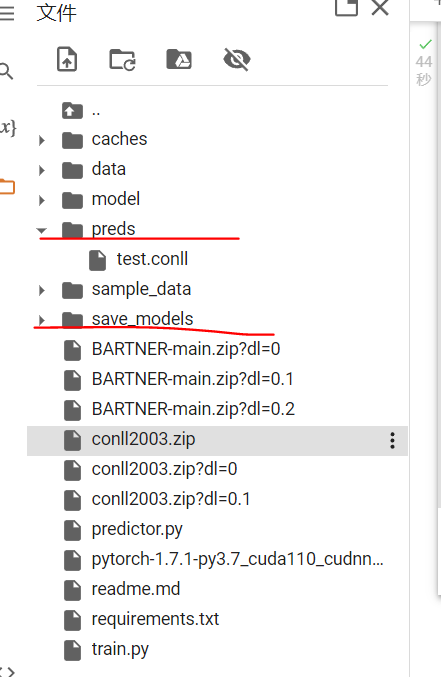